#### TIC ID's

- simple: 427685831 
- clear: 200723869 
- success 1: 248853232 
- success 2: 86263325 
- harder: 455784423

In [1]:
TIC = str(f"TIC {input("TIC: ")}")

TIC:  248853232


In [94]:
%matplotlib widget
import statistics
import matplotlib.pyplot as plt
import lightkurve as lk
import numpy as np
from astropy import units as u
from lightkurve import search_targetpixelfile
from lightkurve import LightCurve
from astroquery.mast import Catalogs

In [3]:
def learn(obj): #this should give object tree like cv
    print("lightkurve: https://lightkurve.github.io/lightkurve/reference/index.html")
    print("astropy: https://docs.astropy.org/en/stable/index_user_docs.html#")
    print("numpy: https://numpy.org/doc/stable/reference/index.html")
    print("matplotlib: https://matplotlib.org/stable/api/index.html")
    type(obj)
    dir(obj)
    help(obj)

In [4]:
def import_data(TIC):    
    lc_data = lk.search_lightcurve(TIC, author = "SPOC", exptime = 120)
    return lc_data
data = import_data(TIC)

def sectors(data):
    selected_sectors = []
    for sector in data.table:
        selected_sectors.append(int(sector["sequence_number"]))
    return selected_sectors
sectors = sectors(data)

data

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 55,2022,SPOC,120,248853232,0.0
1,TESS Sector 81,2024,SPOC,120,248853232,0.0
2,TESS Sector 92,2025,SPOC,120,248853232,0.0


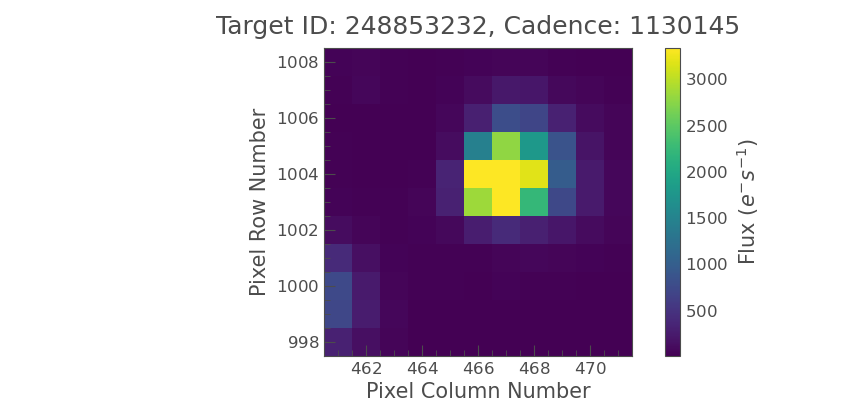

In [16]:
def pixel_file(TIC, sectors):
    pxfile = search_targetpixelfile(TIC, author = "SPOC", exptime = 120, sector = sectors[0]).download()
    pxfile.plot()
pixel_file(TIC, sectors)

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

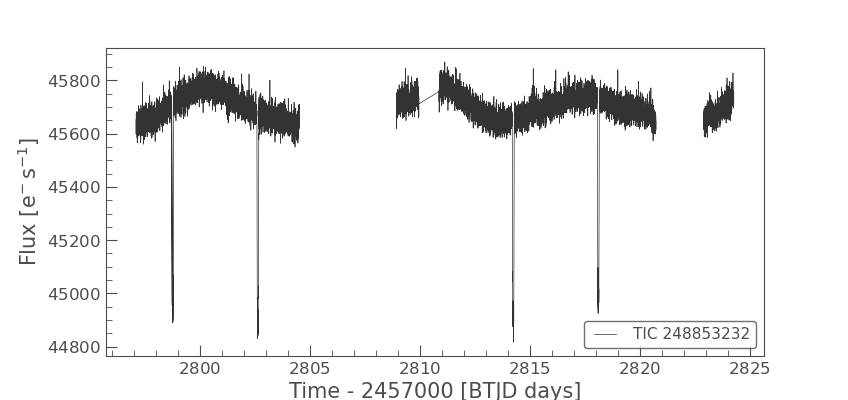

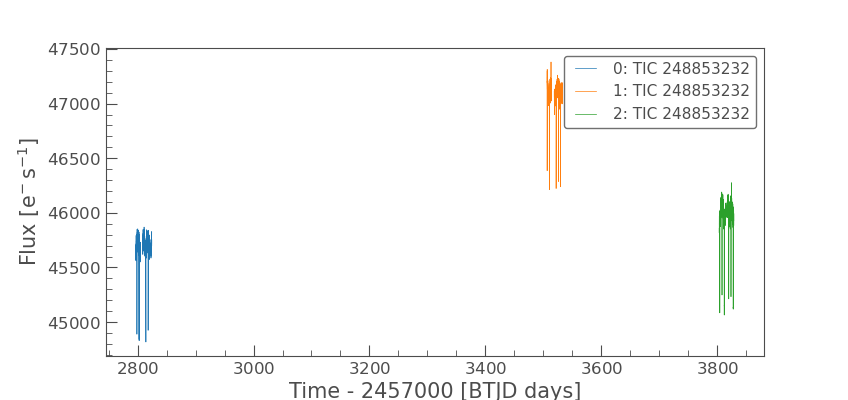

In [6]:
def time_series(TIC, data, sectors):
    download_first = lk.search_lightcurve(TIC, author = "SPOC", exptime = 120, sector = sectors[0]).download()
    if len(sectors) > 1:
        download_all = lk.search_lightcurve(TIC, author = "SPOC", exptime = 120, sector = sectors).download_all()
    else:
        download_all = lk.search_lightcurve(TIC, author = "SPOC", exptime = 120, sector = 0).download()
    return download_first, download_all
ts_first, ts_all = time_series(TIC, data, sectors)

ts_first.plot()
ts_all.plot()

In [55]:
flatten_flux = {}
for ts in ts_all:
    flatten_flux[ts.sector] = ts.flatten()
#===========================
ts_minimums = {}
for ts in flatten_flux.values():
    ts_minimums[ts.sector] = ts.flux.value.min()
    
greatest_min = np.nanmin(list(ts_minimums.values()))

for ts in flatten_flux.values():
    if ts.flux.value.min() == greatest_min:
        min_sector = ts.sector

print(f"minimums: {ts_minimums}")
print(f"greatest min: {greatest_min}")
print()
#===========================
sector_transits = {}
for ts in flatten_flux.values():
    if ts.flux.value.min() < greatest_min + (.2 * (1 - greatest_min)):
        sector_transits[ts.sector] = "yes"
    else:
        sector_transits[ts.sector] = "no"
        
print(f"potential transit?: {sector_transits}")

minimums: {55: MaskedNDArray(0.98146739), 81: MaskedNDArray(0.98180346), 92: MaskedNDArray(0.98174934)}
greatest min: 0.9814673930998769

potential transit?: {55: 'yes', 81: 'yes', 92: 'yes'}


sector 55 transit count: 4
sector 81 transit count: 5
sector 92 transit count: 6
estimate orbital period: 4.5


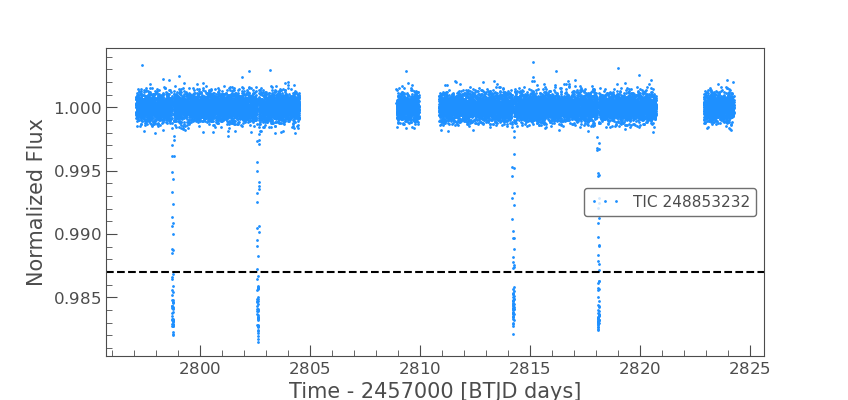

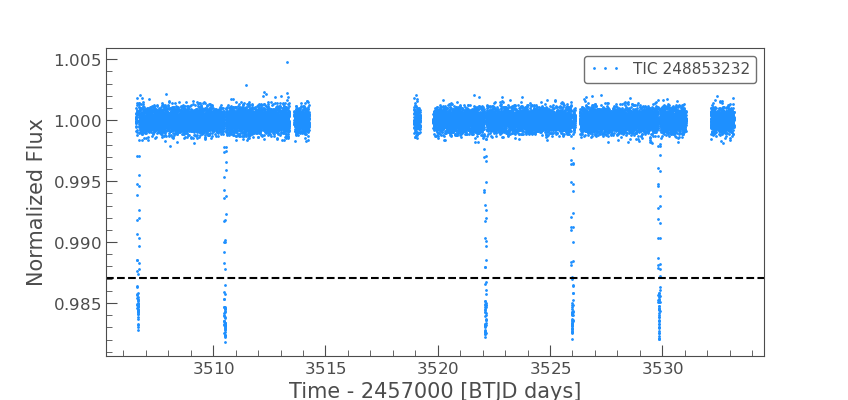

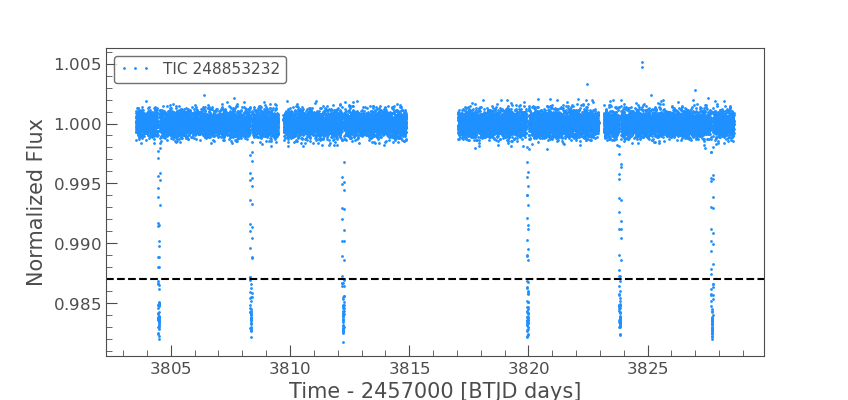

In [8]:
def count_transits(flatten_ts, greatest_min):
    transit_depth = 1 - greatest_min
    transit_threshold = greatest_min + (.3 * transit_depth)
    below = np.asarray(flatten_ts.flux.value < transit_threshold)
    min_duration = 5
    transit_length = 0
    transit_count = 0 
    for flux in below:
        if flux:
            transit_length += 1
        elif transit_length >= min_duration:
            transit_count += 1
            transit_length = 0 
    return transit_count, transit_threshold
potential_transits, threshold = count_transits(ts, greatest_min)

sector_transit_counts = {}
for sector, ts in flatten_flux.items():
    if sector_transits[sector] == "yes":
        sector_transit_counts[sector] = count_transits(ts, greatest_min)[0]
        print(f"sector {sector} transit count: {count_transits(ts, greatest_min)[0]}")   
        ts.plot(linewidth = 0, marker = '.', color = 'dodgerblue')
        plt.axhline(threshold, color = 'black', linestyle = '--')

for sector, transits in sector_transit_counts.items():
    if transits == max(sector_transit_counts.values()):
        target_ts = sector
        
print(f"estimate orbital period: {27/max(sector_transit_counts.values())}")

3.867705442902721 d
3804.4845181711116


<Axes: xlabel='Period [$\\mathrm{d}$]', ylabel='BLS Power'>

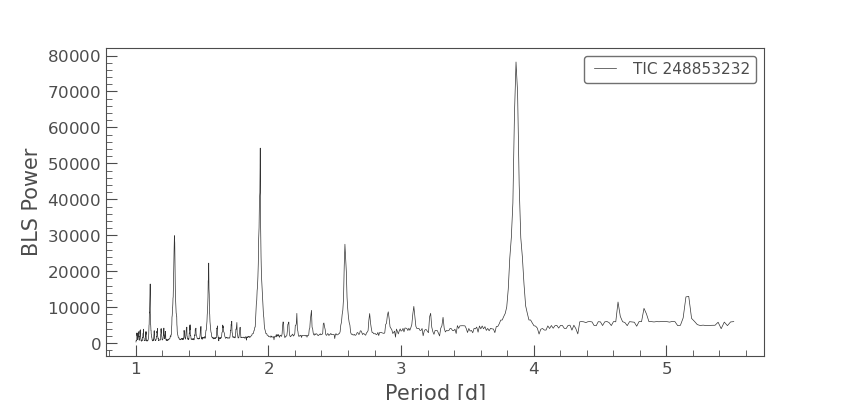

In [34]:
def periodogram(single_ts):
    estimate_period = 27/max(sector_transit_counts.values())
    max_period = estimate_period + 1
    min_period = estimate_period - 1
    periodogram = single_ts.to_periodogram(method = "bls", minimum_period = 1, maximum_period = max_period)
    orbital_period = periodogram.period_at_max_power
    t0 = periodogram.transit_time_at_max_power
    return periodogram, orbital_period, t0
periodogram, orbital_period, t0 = periodogram(flatten_flux[target_ts].bin(60/60/24))

print(orbital_period)
print(t0)
periodogram.plot()

3.8681358427544454 d
2798.7763251368897


<Axes: xlabel='Period [$\\mathrm{d}$]', ylabel='BLS Power'>

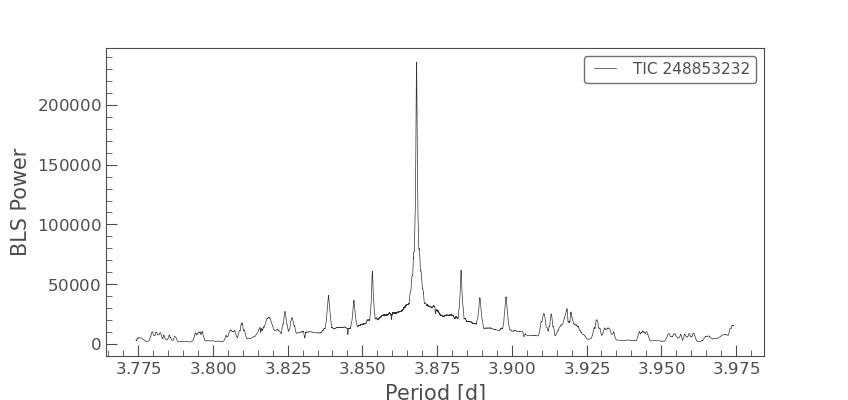

In [10]:
stitch_me = ts_all
fold_me = stitch_me.stitch()

def periodogram(stitch_ts, op):
    estimate_period = op.value
    max_period = estimate_period + .1
    min_period = estimate_period - .1
    new_periodogram = stitch_ts.to_periodogram(method = "bls", minimum_period = min_period, maximum_period = max_period)
    new_orbital_period = new_periodogram.period_at_max_power
    new_t0 = new_periodogram.transit_time_at_max_power
    return new_periodogram, new_orbital_period, new_t0
new_periodogram, new_orbital_period, new_t0 = periodogram(fold_me, orbital_period) #.bin(30/60/24)

print(new_orbital_period)
print(new_t0)
new_periodogram.plot()

transit depth: 0.016938303198133164


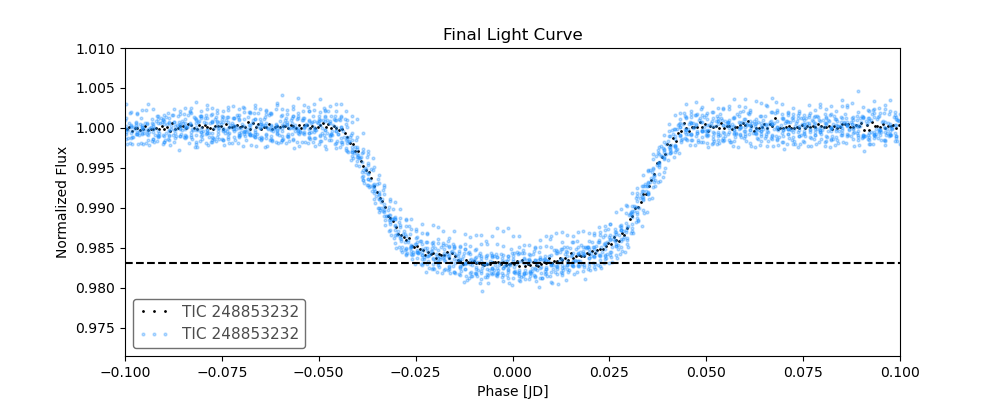

In [105]:
plot_me = fold_me.fold(period = new_orbital_period, epoch_time = new_t0)
bin_me = plot_me.bin(1/60/24)

phase_points = (-0.01 * u.day < bin_me.phase) & (bin_me.phase < 0.01 * u.day)
dip = np.mean(bin_me.flux[phase_points])
depth = 1 - dip
print(f"transit depth: {depth}")

fig, ax = plt.subplots(figsize = (10,4))
bin_me.plot(ax = ax, linewidth = ' 0', marker = ".", color = "black")
plot_me.plot(ax = ax, linewidth = ' 0', marker = "o", color = "dodgerblue", alpha = .3)
plt.title("Final Light Curve")
plt.axhline(dip, color = 'black', linestyle = '--')
plt.xlim(-.1,.1)
plt.ylim(greatest_min - .01, 1.01)
plt.show()

In [106]:
star = Catalogs.query_object(TIC, catalog = "TIC")
r_pl_solar_radius = np.sqrt(depth) * (star["rad"][0] * u.R_sun)
r_pl_earth_radius = r_pl_solar_radius.to(u.Rearth)
r_pl_jupiter_radius = r_pl_solar_radius.to(u.Rjupiter)

print('Radius:')
print(r_pl_earth_radius)
print(r_pl_jupiter_radius)

Radius:
12.458271504312517 earthRad
1.1114544491922966 jupiterRad


#### Ideas for improvement
- cut nan areas and count transits the divide by 27 (or time not cut) and give 1 day buffer for periodogram search
- adjust depth and duration thresholds n to r ratio
- remove nans and outliers
- test false positives
- compare results with astroquery